# 20-13. 프로젝트 : Segmentation map으로 도로 이미지 만들기


프로젝트 수행

프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같습니다.

   1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해주세요.
    (어떠한 방법을 사용했는지 적어주세요.)
   2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해주세요.
   3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용해주세요.
   4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.
   5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.


In [13]:
# 모듈 
# 데이터로드
import os 

#시각화
import cv2 
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf


In [3]:
# 훈련 데이터 로드

train_data_path = os.getenv('HOME')+'/aiffel/cityscapes/train/'
print("number of train examples :", len(os.listdir(train_data_path)))

number of train examples : 1000


In [4]:
# 테스트 데이터 로드

test_data_path = os.getenv('HOME')+'/aiffel/cityscapes/val/'
print("number of test examples :", len(os.listdir(test_data_path)))

number of test examples : 5


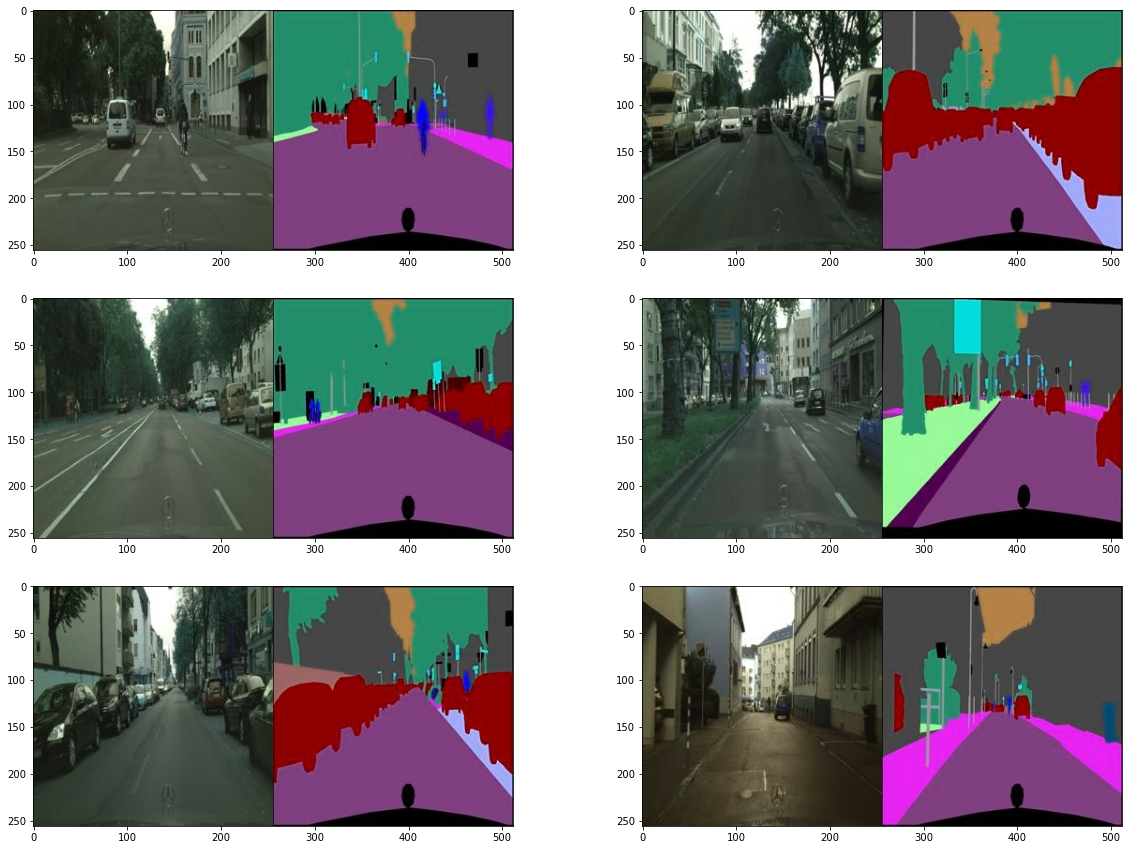

In [7]:
# 임의의 6개 이미지 시각화

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(train_data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [8]:
# 이미지 하나 열어서 크기 확인해보기
f = train_data_path + os.listdir(train_data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


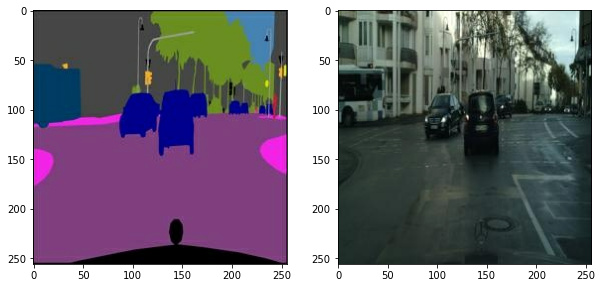

In [12]:
# 이미지 나누기

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    segment = img[:, w:, :]
    segment = tf.cast(segment, tf.float32)
    real = img[:, :w, :]
    real = tf.cast(real, tf.float32)
    return normalize(segment), normalize(real)

f = train_data_path + os.listdir(train_data_path)[1]
segment, real = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(segment))
plt.subplot(1,2,2); plt.imshow(denormalize(real))
plt.show()

### augmentation 적용하기
    1. 두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다.

    2. 1.의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)

    3. 2.의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop) 

    4. 3.의 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)

    5. 4.의 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down) 

    6. 5.의 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)


In [14]:
# 학습 데이터 다양성을 높이기 위해 augmentation 적용
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):  # 스케치, 채색 이미지 2개를 받아 연산을 동일하게 적용함
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


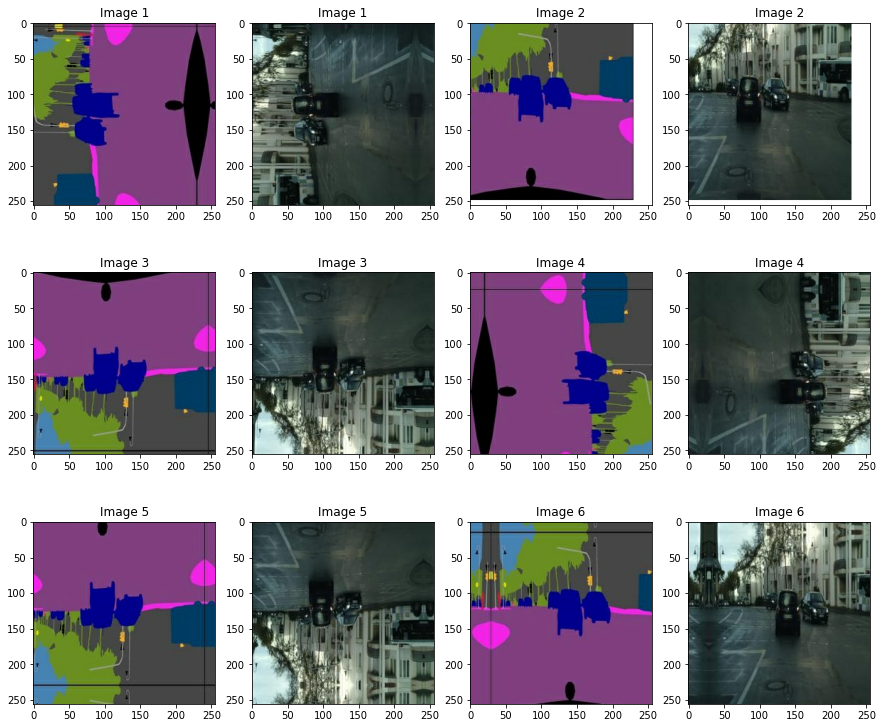

In [16]:
# 위의 함수를 데이터에 적용하여 시각화
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_segment, augmented_real = apply_augmentation(segment, real)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_segment)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_real)); plt.title(f"Image {img_n}")
    img_n += 1

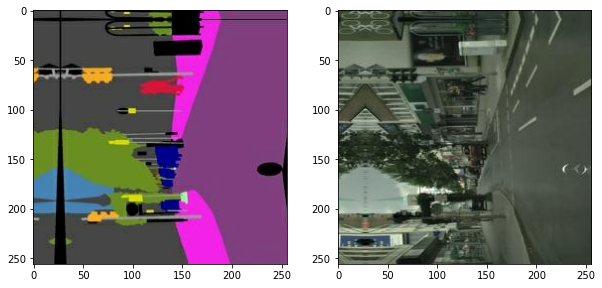

In [17]:
# 잘 적용 되었는지 1개 이미지 시각화
from tensorflow import data

def get_train(img_path):
    segment, real = load_img(img_path)
    segment, real = apply_augmentation(segment, real)
    return segment, real

train_images = data.Dataset.list_files(train_data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
segment, real = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(segment[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(real[0].astype(np.uint8))

#### Generator 구현하기
- 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해주세요.

In [19]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [20]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512] # 각 블록을 거치면서 사용할 필터의 개수
        
        self.blocks = [] # 사용할 블록들을 정의해 넣어두기
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    # Encoder 첫 번째 블록에서는 BatchNorm을 사용하지 않습니다.
    
    def call(self, x): # 차례대로 블록들을 통과한다.
        for block in self.blocks:
            x = block(x)
        return x
    
    # 레이어가 제대로 구성되었는지 확인하기
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


In [22]:
# 위에서 구성한 Encoder에 (256,256,3)크기의 데이터를 입력했을때
# 어떤 데이터 크기의 데이터가 출력되는지 살펴보기
Encoder().get_summary()  # 만들어놓은 get_summary 메서드 불러오기

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

In [21]:
# Decoder 구현 - Encoder와 마찬가지로 사용할 기본 블록을 정의하고, 이 블록을 여러번 반복하여 만듦
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3: # 처음 3개 블록에만 Dropout사용 
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
        # 마지막 convolution에는 3개의 필터를 사용해 출력하는 것을 확인할 수 있다.        
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

In [23]:
# (1,1,512) 크기의 데이터가 입력되었을 때, 어떤 크기가 출력되는가
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

In [24]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


In [25]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [26]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [27]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

### Discriminator 구성하기

In [28]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 


In [29]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [30]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [31]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

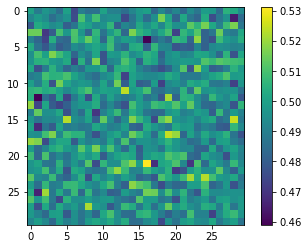

In [32]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

### 학습 후 테스트 하기

In [33]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)


In [34]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)


In [35]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [36]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8332                     
L1_loss:0.3662                     
Discriminator_loss:1.2885

EPOCH[1] - STEP[20]                     
Generator_loss:0.8305                     
L1_loss:0.2250                     
Discriminator_loss:1.2682

EPOCH[1] - STEP[30]                     
Generator_loss:0.6787                     
L1_loss:0.2177                     
Discriminator_loss:1.6911

EPOCH[1] - STEP[40]                     
Generator_loss:0.8375                     
L1_loss:0.2569                     
Discriminator_loss:1.1883

EPOCH[1] - STEP[50]                     
Generator_loss:1.1860                     
L1_loss:0.1978                     
Discriminator_loss:1.3138

EPOCH[1] - STEP[60]                     
Generator_loss:0.9661                     
L1_loss:0.2279                     
Discriminator_loss:1.1530

EPOCH[1] - STEP[70]                     
Generator_loss:1.0313                     
L1_loss:0.2009                    

EPOCH[3] - STEP[70]                     
Generator_loss:3.7612                     
L1_loss:0.1816                     
Discriminator_loss:1.5156

EPOCH[3] - STEP[80]                     
Generator_loss:1.6752                     
L1_loss:0.2520                     
Discriminator_loss:0.3652

EPOCH[3] - STEP[90]                     
Generator_loss:1.4325                     
L1_loss:0.1933                     
Discriminator_loss:1.1302

EPOCH[3] - STEP[100]                     
Generator_loss:1.9566                     
L1_loss:0.1719                     
Discriminator_loss:1.8640

EPOCH[3] - STEP[110]                     
Generator_loss:1.9033                     
L1_loss:0.2231                     
Discriminator_loss:0.3636

EPOCH[3] - STEP[120]                     
Generator_loss:0.7530                     
L1_loss:0.1636                     
Discriminator_loss:1.2599

EPOCH[3] - STEP[130]                     
Generator_loss:0.9162                     
L1_loss:0.1716                

EPOCH[5] - STEP[130]                     
Generator_loss:1.1288                     
L1_loss:0.1636                     
Discriminator_loss:0.6437

EPOCH[5] - STEP[140]                     
Generator_loss:1.5948                     
L1_loss:0.1950                     
Discriminator_loss:0.3448

EPOCH[5] - STEP[150]                     
Generator_loss:1.5576                     
L1_loss:0.1607                     
Discriminator_loss:0.6321

EPOCH[5] - STEP[160]                     
Generator_loss:1.4926                     
L1_loss:0.1722                     
Discriminator_loss:1.3145

EPOCH[5] - STEP[170]                     
Generator_loss:1.0778                     
L1_loss:0.1696                     
Discriminator_loss:0.6330

EPOCH[5] - STEP[180]                     
Generator_loss:2.1741                     
L1_loss:0.2141                     
Discriminator_loss:0.2811

EPOCH[5] - STEP[190]                     
Generator_loss:1.3998                     
L1_loss:0.1905             

EPOCH[7] - STEP[190]                     
Generator_loss:1.1318                     
L1_loss:0.1607                     
Discriminator_loss:1.1595

EPOCH[7] - STEP[200]                     
Generator_loss:0.4787                     
L1_loss:0.1722                     
Discriminator_loss:1.1163

EPOCH[7] - STEP[210]                     
Generator_loss:1.6942                     
L1_loss:0.1839                     
Discriminator_loss:0.5180

EPOCH[7] - STEP[220]                     
Generator_loss:3.3444                     
L1_loss:0.1712                     
Discriminator_loss:1.0728

EPOCH[7] - STEP[230]                     
Generator_loss:2.2804                     
L1_loss:0.1698                     
Discriminator_loss:1.2293

EPOCH[7] - STEP[240]                     
Generator_loss:0.9910                     
L1_loss:0.1842                     
Discriminator_loss:0.8056

EPOCH[7] - STEP[250]                     
Generator_loss:1.7634                     
L1_loss:0.1840             

EPOCH[9] - STEP[250]                     
Generator_loss:0.5212                     
L1_loss:0.1904                     
Discriminator_loss:1.1398

EPOCH[10] - STEP[10]                     
Generator_loss:0.8972                     
L1_loss:0.1586                     
Discriminator_loss:1.1555

EPOCH[10] - STEP[20]                     
Generator_loss:1.3945                     
L1_loss:0.1909                     
Discriminator_loss:0.4147

EPOCH[10] - STEP[30]                     
Generator_loss:0.8326                     
L1_loss:0.2011                     
Discriminator_loss:0.7950

EPOCH[10] - STEP[40]                     
Generator_loss:2.2660                     
L1_loss:0.1420                     
Discriminator_loss:1.8082

EPOCH[10] - STEP[50]                     
Generator_loss:1.1065                     
L1_loss:0.1890                     
Discriminator_loss:0.7156

EPOCH[10] - STEP[60]                     
Generator_loss:0.7661                     
L1_loss:0.1733             

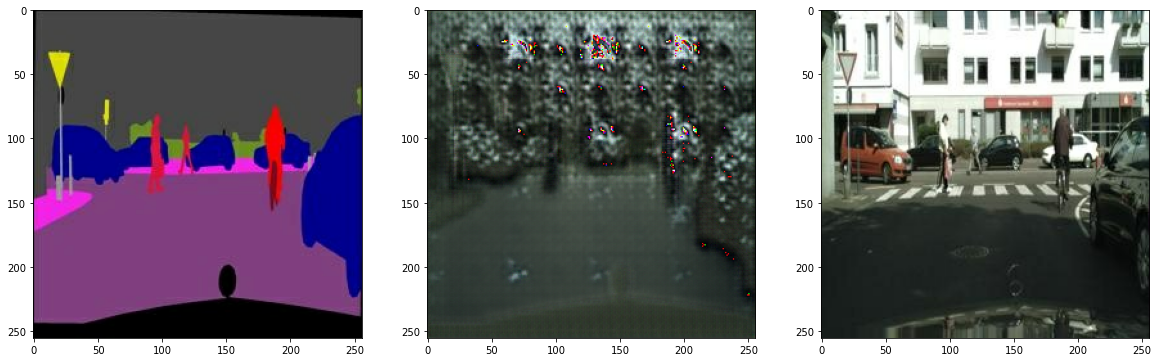

In [38]:
test_ind = 1

f = test_data_path + os.listdir(test_data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

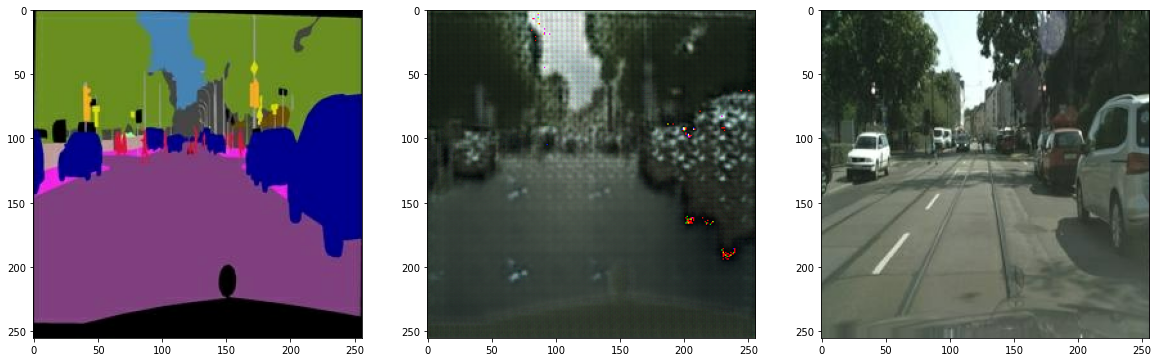

In [39]:
test_ind = 2

f = test_data_path + os.listdir(test_data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

## 총평
- 확실히 Epoch를 낮게 하기 처참한 결과의 사진이 생성되었다. 시간을 더 투자해서 Epoch를 더 높여보아야겠다.